# Projeto Final de Processamento de Linguagem Natural

## Análise de sentimentos

André Souza Santos

Augusto Piai S Fernandez

Juan Pablo

# Pré-processamento

In [112]:
import pandas as pd
from IPython.display import display
import re
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
from nltk.stem import RSLPStemmer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
from IPython.display import display
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from transformers import pipeline
from sklearn.metrics.pairwise import cosine_similarity

In [113]:
arquivo_positivo = 'books_pt_pos.txt'
arquivo_negativo = 'books_pt_neg.txt'

with open(arquivo_positivo, encoding='utf-8') as f:
    positivos = [linha.strip() for linha in f if linha.strip()]

with open(arquivo_negativo, encoding='utf-8') as f:
    negativos = [linha.strip() for linha in f if linha.strip()]

df_positivos = pd.DataFrame({'classe': 'positivo', 'review': positivos})
df_negativos = pd.DataFrame({'classe': 'negativo', 'review': negativos})

df_reviews = pd.concat([df_positivos, df_negativos], ignore_index=True)

display(df_reviews.head())

,classe,review
0,positivo,Enfim o final da série chegou e me deixou arre...
1,positivo,Aiai! Agora ficamos órfãos dos Lafaiete 😔 A hi...
2,positivo,"Lara smithe fechou a série com chave de ouro,q..."
3,positivo,Mais uma vez a Lara Smithe nos deixa de boca a...
4,positivo,Ótima ideia: aglutinar os livros dos quatro ir...


In [114]:
print("=== PRÉ-PROCESSAMENTO DOS DADOS ===")

def limpar_texto(texto):
    texto = texto.lower()

    texto = re.sub(r'[^a-záàâãéêíóôõúç\s]', ' ', texto)

    texto = re.sub(r'\s+', ' ', texto)

    return texto.strip()

print("Aplicando limpeza nos textos...")
df_reviews['review_limpo'] = df_reviews['review'].apply(limpar_texto)

df_reviews['tamanho_limpo'] = df_reviews['review_limpo'].str.len()
df_reviews['palavras_limpo'] = df_reviews['review_limpo'].str.split().str.len()

print("\n=== ESTATÍSTICAS APÓS LIMPEZA ===")
print(f"Tamanho médio após limpeza: {df_reviews['tamanho_limpo'].mean():.2f} caracteres")
print(f"Número médio de palavras após limpeza: {df_reviews['palavras_limpo'].mean():.2f}")

print("\n=== EXEMPLO DE LIMPEZA ===")
print(f"ANTES: {df_reviews['review'].iloc[0]}")
print(f"DEPOIS: {df_reviews['review_limpo'].iloc[0]}")

display(df_reviews[['classe', 'review_limpo', 'tamanho_limpo', 'palavras_limpo']].head())

=== PRÉ-PROCESSAMENTO DOS DADOS ===
Aplicando limpeza nos textos...

=== ESTATÍSTICAS APÓS LIMPEZA ===
Tamanho médio após limpeza: 349.58 caracteres
Número médio de palavras após limpeza: 61.06

=== EXEMPLO DE LIMPEZA ===
ANTES: Enfim o final da série chegou e me deixou arrebatada e emocionada. Um final cheio de amor e lembranças, perfeito para uma série tão emocionante e intensa. Mauricio era o último dos Lafaietes solteiro, mas Eleonora arrebatou seu coração, ainda que não estivesse nos seus planos. Ele desde sempre soube o que queria e correu atrás para realizar os seus sonhos. Eleonora não foi uma mocinha fácil e dócil. Maumau ao contrário, decidido, intenso e apaixonado. Uma história cativante, que vai te envolvendo. O amor não tem idade e não vê traumas e preconceitos, ele vai arrebatando e tudo supera, e foi exatamente isso que a autora foi nos revelando aos poucos. Uma história de superação, perdão e aceitação. Um final repleto de figuras queridas e cheio de lágrimas e emoção. 

,classe,review_limpo,tamanho_limpo,palavras_limpo
0,positivo,enfim o final da série chegou e me deixou arre...,864,147
1,positivo,aiai agora ficamos órfãos dos lafaiete a histó...,708,121
2,positivo,lara smithe fechou a série com chave de ouro q...,139,25
3,positivo,mais uma vez a lara smithe nos deixa de boca a...,379,77
4,positivo,ótima ideia aglutinar os livros dos quatro irm...,247,39


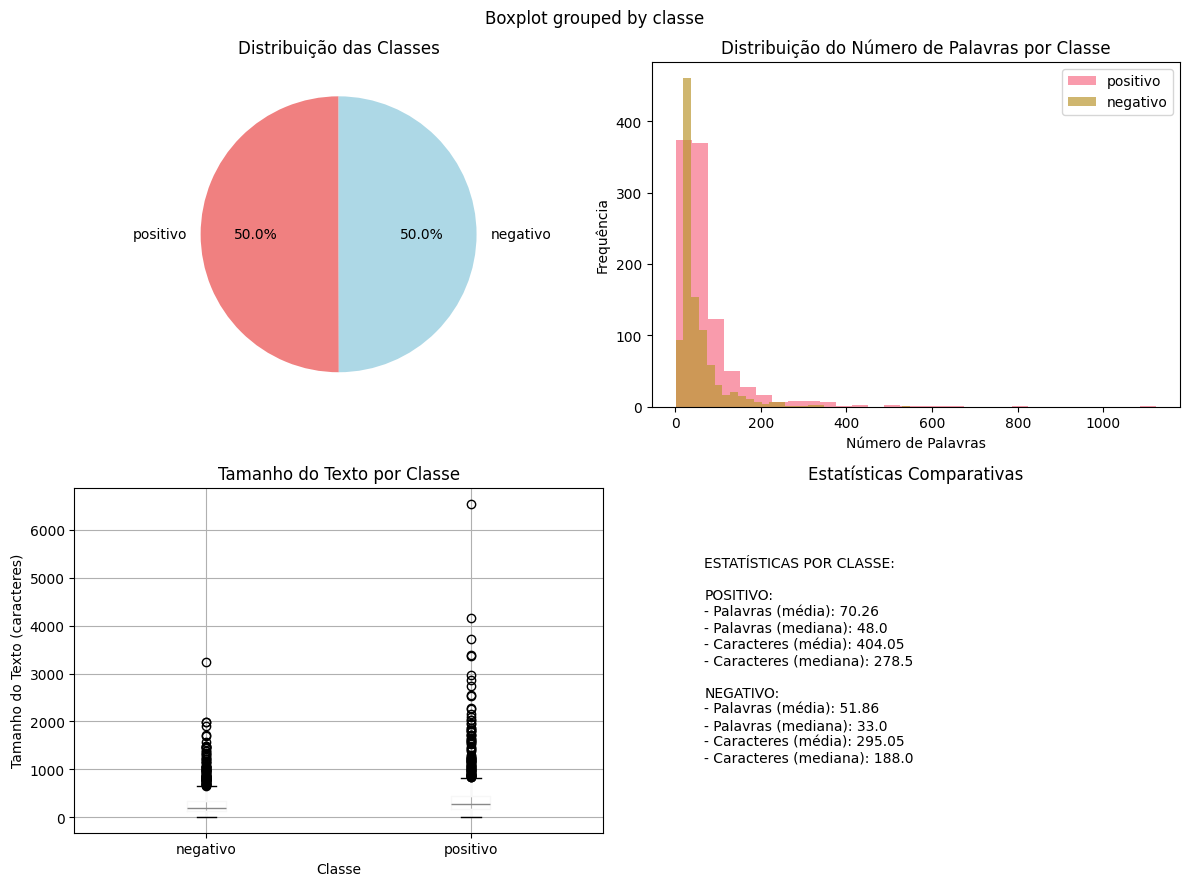

In [129]:
plt.style.use('default')
sns.set_palette("husl")

fig, axes = plt.subplots(2, 2, figsize=(12, 9))
fig.suptitle('Análise Exploratória dos Dados de Reviews', fontsize=16, fontweight='bold')

axes[0, 0].pie(df_reviews['classe'].value_counts(),
               labels=df_reviews['classe'].value_counts().index,
               autopct='%1.1f%%',
               startangle=90,
               colors=['lightcoral', 'lightblue'])
axes[0, 0].set_title('Distribuição das Classes')

for classe in df_reviews['classe'].unique():
    data = df_reviews[df_reviews['classe'] == classe]['palavras_limpo']
    axes[0, 1].hist(data, alpha=0.7, label=classe, bins=30)
axes[0, 1].set_xlabel('Número de Palavras')
axes[0, 1].set_ylabel('Frequência')
axes[0, 1].set_title('Distribuição do Número de Palavras por Classe')
axes[0, 1].legend()

df_reviews.boxplot(column='tamanho_limpo', by='classe', ax=axes[1, 0])
axes[1, 0].set_title('Tamanho do Texto por Classe')
axes[1, 0].set_xlabel('Classe')
axes[1, 0].set_ylabel('Tamanho do Texto (caracteres)')

stats_data = df_reviews.groupby('classe').agg({
    'palavras_limpo': ['mean', 'median'],
    'tamanho_limpo': ['mean', 'median']
}).round(2)

stats_text = f"""
ESTATÍSTICAS POR CLASSE:

POSITIVO:
- Palavras (média): {stats_data.loc['positivo', ('palavras_limpo', 'mean')]}
- Palavras (mediana): {stats_data.loc['positivo', ('palavras_limpo', 'median')]}
- Caracteres (média): {stats_data.loc['positivo', ('tamanho_limpo', 'mean')]}
- Caracteres (mediana): {stats_data.loc['positivo', ('tamanho_limpo', 'median')]}

NEGATIVO:
- Palavras (média): {stats_data.loc['negativo', ('palavras_limpo', 'mean')]}
- Palavras (mediana): {stats_data.loc['negativo', ('palavras_limpo', 'median')]}
- Caracteres (média): {stats_data.loc['negativo', ('tamanho_limpo', 'mean')]}
- Caracteres (mediana): {stats_data.loc['negativo', ('tamanho_limpo', 'median')]}
"""

axes[1, 1].text(0.1, 0.5, stats_text, fontsize=10, verticalalignment='center')
axes[1, 1].set_xlim(0, 1)
axes[1, 1].set_ylim(0, 1)
axes[1, 1].axis('off')
axes[1, 1].set_title('Estatísticas Comparativas')

plt.tight_layout()
plt.show()

In [116]:
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

stop_words = set(stopwords.words('portuguese'))

print("=== REMOÇÃO DE STOPWORDS ===")
print(f"Total de stopwords em português: {len(stop_words)}")
print(f"Primeiras 20 stopwords: {list(stop_words)[:20]}")

def remover_stopwords(texto):
    palavras = texto.split()
    palavras_filtradas = [palavra for palavra in palavras if palavra.lower() not in stop_words]
    return ' '.join(palavras_filtradas)

print("\nAplicando remoção de stopwords...")
df_reviews['review_sem_stopwords'] = df_reviews['review_limpo'].apply(remover_stopwords)

df_reviews['palavras_sem_stopwords'] = df_reviews['review_sem_stopwords'].str.split().str.len()
df_reviews['tamanho_sem_stopwords'] = df_reviews['review_sem_stopwords'].str.len()

print("\n=== ESTATÍSTICAS APÓS REMOÇÃO DE STOPWORDS ===")
print(f"Palavras médias antes: {df_reviews['palavras_limpo'].mean():.2f}")
print(f"Palavras médias depois: {df_reviews['palavras_sem_stopwords'].mean():.2f}")
print(f"Redução média: {((df_reviews['palavras_limpo'].mean() - df_reviews['palavras_sem_stopwords'].mean()) / df_reviews['palavras_limpo'].mean() * 100):.1f}%")

print("\n=== EXEMPLO DE REMOÇÃO DE STOPWORDS ===")
idx_exemplo = 0
print(f"ORIGINAL: {df_reviews['review_limpo'].iloc[idx_exemplo]}")
print(f"SEM STOPWORDS: {df_reviews['review_sem_stopwords'].iloc[idx_exemplo]}")

print("\n=== ESTATÍSTICAS POR CLASSE (SEM STOPWORDS) ===")
stats_sem_stopwords = df_reviews.groupby('classe')['palavras_sem_stopwords'].agg(['mean', 'median']).round(2)
print(stats_sem_stopwords)

display(df_reviews[['classe', 'review_sem_stopwords', 'palavras_sem_stopwords', 'tamanho_sem_stopwords']].head())

=== REMOÇÃO DE STOPWORDS ===
Total de stopwords em português: 207
Primeiras 20 stopwords: ['terei', 'houvéramos', 'seu', 'houverem', 'estiveram', 'e', 'até', 'pela', 'se', 'numa', 'houver', 'nos', 'mesmo', 'tu', 'do', 'estejam', 'há', 'sou', 'esteja', 'teremos']

Aplicando remoção de stopwords...

=== ESTATÍSTICAS APÓS REMOÇÃO DE STOPWORDS ===
Palavras médias antes: 61.06
Palavras médias depois: 33.80
Redução média: 44.7%

=== EXEMPLO DE REMOÇÃO DE STOPWORDS ===
ORIGINAL: enfim o final da série chegou e me deixou arrebatada e emocionada um final cheio de amor e lembranças perfeito para uma série tão emocionante e intensa mauricio era o último dos lafaietes solteiro mas eleonora arrebatou seu coração ainda que não estivesse nos seus planos ele desde sempre soube o que queria e correu atrás para realizar os seus sonhos eleonora não foi uma mocinha fácil e dócil maumau ao contrário decidido intenso e apaixonado uma história cativante que vai te envolvendo o amor não tem idade e não vê tra

,classe,review_sem_stopwords,palavras_sem_stopwords,tamanho_sem_stopwords
0,positivo,enfim final série chegou deixou arrebatada emo...,79,630
1,positivo,aiai agora ficamos órfãos lafaiete história am...,64,509
2,positivo,lara smithe fechou série chave ouro amor lindo...,15,101
3,positivo,vez lara smithe deixa boca aberta saber dizer ...,38,257
4,positivo,ótima ideia aglutinar livros quatro irmãos laf...,26,208


In [117]:
try:
    nltk.data.find('stemmers/rslp')
except LookupError:
    nltk.download('rslp')


stemmer = RSLPStemmer()

print("=== STEMMING ===")

def aplicar_stemming(texto):
    palavras = texto.split()
    palavras_stemmadas = [stemmer.stem(palavra) for palavra in palavras]
    return ' '.join(palavras_stemmadas)

print("\nAplicando stemming nos textos sem stopwords...")
df_reviews['review_stemmado'] = df_reviews['review_sem_stopwords'].apply(aplicar_stemming)

df_reviews['palavras_stemmadas'] = df_reviews['review_stemmado'].str.split().str.len()
df_reviews['tamanho_stemmado'] = df_reviews['review_stemmado'].str.len()

print("\n=== ESTATÍSTICAS APÓS STEMMING ===")
print(f"Palavras médias antes (sem stopwords): {df_reviews['palavras_sem_stopwords'].mean():.2f}")
print(f"Palavras médias depois (stemmadas): {df_reviews['palavras_stemmadas'].mean():.2f}")
print(f"Redução média: {((df_reviews['palavras_sem_stopwords'].mean() - df_reviews['palavras_stemmadas'].mean()) / df_reviews['palavras_sem_stopwords'].mean() * 100):.1f}%")


print("\n=== EXEMPLO DE STEMMING ===")
idx_exemplo = 0
print(f"SEM STOPWORDS: {df_reviews['review_sem_stopwords'].iloc[idx_exemplo]}")
print(f"STEMMADO: {df_reviews['review_stemmado'].iloc[idx_exemplo]}")

print("\n=== ESTATÍSTICAS POR CLASSE (STEMMADO) ===")
stats_stemmado = df_reviews.groupby('classe')['palavras_stemmadas'].agg(['mean', 'median']).round(2)
print(stats_stemmado)


display(df_reviews[['classe', 'review_stemmado', 'palavras_stemmadas', 'tamanho_stemmado']].head())


=== STEMMING ===

Aplicando stemming nos textos sem stopwords...

=== ESTATÍSTICAS APÓS STEMMING ===
Palavras médias antes (sem stopwords): 33.80
Palavras médias depois (stemmadas): 33.80
Redução média: 0.0%

=== EXEMPLO DE STEMMING ===
SEM STOPWORDS: enfim final série chegou deixou arrebatada emocionada final cheio amor lembranças perfeito série tão emocionante intensa mauricio último lafaietes solteiro eleonora arrebatou coração ainda planos desde sempre soube queria correu atrás realizar sonhos eleonora mocinha fácil dócil maumau contrário decidido intenso apaixonado história cativante vai envolvendo amor idade vê traumas preconceitos vai arrebatando tudo supera exatamente autora revelando poucos história superação perdão aceitação final repleto figuras queridas cheio lágrimas emoção definitivamente ressaca literária lafaietes sempre pedacinho coração super recomendo
STEMMADO: enfim final séri cheg deix arrebat emocion final chei am lembranç perfeit séri tão emocion intens maurici ú

,classe,review_stemmado,palavras_stemmadas,tamanho_stemmado
0,positivo,enfim final séri cheg deix arrebat emocion fin...,79,472
1,positivo,ai agor fic órfã lafaiet histór am mauríci ele...,64,371
2,positivo,lar smith fech séri chav our am lind contagi p...,15,80
3,positivo,vez lar smith deix boc abert sab diz histór ma...,38,207
4,positivo,ótim ide aglutin livr quatr irm lafaiet oferec...,26,157


# Naive Bayes


=== DIVISÃO TREINO/TESTE ===
Tamanho do conjunto de treino: 1599
Tamanho do conjunto de teste: 400
Distribuição das classes no treino:
classe
positivo    0.500313
negativo    0.499687
Name: proportion, dtype: float64
Distribuição das classes no teste:
classe
positivo    0.5
negativo    0.5
Name: proportion, dtype: float64

=== VETORIZAÇÃO DOS TEXTOS ===
Vocabulário gerado: 5567 termos
Shape dos dados de treino vetorizados: (1599, 5567)
Shape dos dados de teste vetorizados: (400, 5567)

=== TREINAMENTO DO MODELO NAIVE BAYES ===
Modelo Naive Bayes treinado com sucesso.

=== AVALIAÇÃO DO MODELO ===
Acurácia: 0.8800

Relatório de Classificação:
              precision    recall  f1-score   support

    negativo       0.90      0.86      0.88       200
    positivo       0.87      0.90      0.88       200

    accuracy                           0.88       400
   macro avg       0.88      0.88      0.88       400
weighted avg       0.88      0.88      0.88       400


Matriz de Confusão:


,Previsto Negativo,Previsto Positivo
Real Negativo,172,28
Real Positivo,20,180


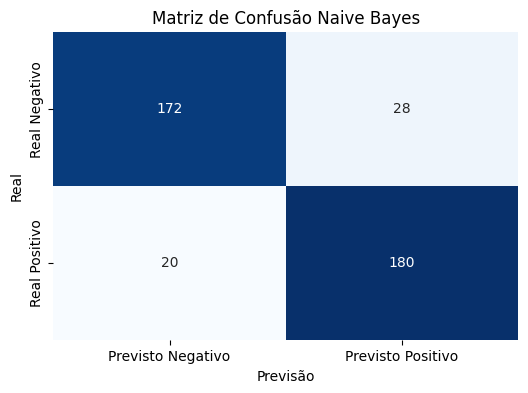


=== TESTE COM NOVO TEXTO ===
Texto original: este livro é incrivelmente chato e sem graça, não recomendo a ninguem
Texto pré-processado: livr incri chat graç recom ning
Previsão da classe: negativo
Probabilidades das classes: ['negativo' 'positivo'] -> [0.9928 0.0072]
Previsão individual salva em: previsoes_individuais.txt
Arquivo carregado com sucesso!
Dimensões do DataFrame: (400, 6)
Colunas disponíveis: ['texto_original', 'classe_real', 'classe_prevista', 'probabilidade_negativa', 'probabilidade_positiva', 'acertou']

--- PRIMEIRAS 10 LINHAS DOS RESULTADOS ---


/usr/local/lib/python3.11/dist-packages/google/colab/_dataframe_summarizer.py:57: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(column, errors="raise")


,texto_original,classe_real,classe_prevista,probabilidade_negativa,probabilidade_positiva,acertou
0,Adorei este livro para entender como funcionam...,positivo,positivo,7.070421e-03,9.929296e-01,True
1,Ótima aquisição. Valeu muito a pena ter compra...,positivo,positivo,1.898354e-01,8.101646e-01,True
2,"Olá, Recebi uma notificação por email que não ...",negativo,negativo,1.000000e+00,2.416758e-10,True
3,"Péssimo, um tentativa de fazer dinheiro apenas...",negativo,negativo,9.996422e-01,3.577654e-04,True
4,minha avalicao sobre o livro e a seguinte: e b...,negativo,negativo,1.000000e+00,3.518872e-08,True
5,Ótima ideia: aglutinar os livros dos quatro ir...,positivo,positivo,5.808511e-08,9.999999e-01,True
6,Podem me explicar do porquê deste preço pra ve...,negativo,negativo,1.000000e+00,1.188185e-08,True
7,O livro é excelente. Um clássico. Assim que fi...,negativo,negativo,9.644606e-01,3.553937e-02,True
8,Sempre o desconfiei como mais um das prateleir...,positivo,positivo,4.880573e-03,9.951194e-01,True
9,Amooooo essa série. Estive acompanhando desde ...,positivo,positivo,1.179468e-04,9.998821e-01,True



--- EXEMPLOS DE CLASSIFICAÇÕES CORRETAS ---


,texto_original,classe_real,classe_prevista,probabilidade_positiva
0,Adorei este livro para entender como funcionam...,positivo,positivo,9.929296e-01
1,Ótima aquisição. Valeu muito a pena ter compra...,positivo,positivo,8.101646e-01
2,"Olá, Recebi uma notificação por email que não ...",negativo,negativo,2.416758e-10
3,"Péssimo, um tentativa de fazer dinheiro apenas...",negativo,negativo,3.577654e-04
4,minha avalicao sobre o livro e a seguinte: e b...,negativo,negativo,3.518872e-08



--- EXEMPLOS DE CLASSIFICAÇÕES INCORRETAS ---


,texto_original,classe_real,classe_prevista,probabilidade_positiva
17,Textos fundamentais! Uma ótima porta de entrad...,positivo,negativo,0.177824
41,Muito lenta a história sem alguma emoção até o...,negativo,positivo,0.882657
43,"Pessoal, vocês vão me desculpar, mas a resenha...",negativo,positivo,0.846826
47,Minha namorada é fã de Harry Potter e resolvi ...,positivo,negativo,0.122873
52,"Amei! Devorei esses livros em 15 dias, gostei...",negativo,positivo,0.976196


<Figure size 640x480 with 0 Axes>

In [119]:
X_train, X_test, y_train, y_test = train_test_split(
    df_reviews['review_stemmado'],
    df_reviews['classe'],
    test_size=0.2,
    random_state=42,
    stratify=df_reviews['classe']
)

textos_originais_teste = df_reviews.loc[X_test.index, 'review']

print("\n=== DIVISÃO TREINO/TESTE ===")
print(f"Tamanho do conjunto de treino: {X_train.shape[0]}")
print(f"Tamanho do conjunto de teste: {X_test.shape[0]}")
print(f"Distribuição das classes no treino:\n{y_train.value_counts(normalize=True)}")
print(f"Distribuição das classes no teste:\n{y_test.value_counts(normalize=True)}")

print("\n=== VETORIZAÇÃO DOS TEXTOS ===")
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
print(f"Vocabulário gerado: {len(vectorizer.vocabulary_)} termos")
print(f"Shape dos dados de treino vetorizados: {X_train_vec.shape}")
print(f"Shape dos dados de teste vetorizados: {X_test_vec.shape}")

print("\n=== TREINAMENTO DO MODELO NAIVE BAYES ===")
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(X_train_vec, y_train)
print("Modelo Naive Bayes treinado com sucesso.")

y_pred = naive_bayes_model.predict(X_test_vec)

print("\n=== AVALIAÇÃO DO MODELO ===")
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia: {accuracy:.4f}")

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

print("\nMatriz de Confusão:")
cm = confusion_matrix(y_test, y_pred)
display(pd.DataFrame(cm, index=['Real Negativo', 'Real Positivo'], columns=['Previsto Negativo', 'Previsto Positivo']))

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Previsto Negativo', 'Previsto Positivo'],
            yticklabels=['Real Negativo', 'Real Positivo'])
plt.title('Matriz de Confusão Naive Bayes')
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.show()

def salvar_classificacoes(textos_originais, textos_processados, y_test, y_pred, probabilidades, nome_arquivo='classificacoes_naive_bayes.csv'):
    """
    Salva as classificações do modelo em um arquivo CSV.

    Parâmetros:
    - textos_originais: textos originais sem processamento
    - textos_processados: textos após pré-processamento
    - y_test: classes reais
    - y_pred: classes previstas
    - probabilidades: probabilidades das previsões
    - nome_arquivo: nome do arquivo de saída
    """
    resultados = pd.DataFrame({
        'texto_original': textos_originais.values,
        'classe_real': y_test.values,
        'classe_prevista': y_pred,
        'probabilidade_negativa': probabilidades[:, 0],
        'probabilidade_positiva': probabilidades[:, 1],
        'acertou': y_test.values == y_pred
    })

    resultados.to_csv(nome_arquivo, index=False, encoding='utf-8')
    print(f"\nClassificações salvas em: {nome_arquivo}")
    print(f"Total de registros salvos: {len(resultados)}")

    return resultados

probabilidades_teste = naive_bayes_model.predict_proba(X_test_vec)

print("\n=== TESTE COM NOVO TEXTO ===")
novo_texto = "este livro é incrivelmente chato e sem graça, não recomendo a ninguem"
novo_texto_limpo = limpar_texto(novo_texto)
novo_texto_sem_stopwords = remover_stopwords(novo_texto_limpo)
novo_texto_stemmado = aplicar_stemming(novo_texto_sem_stopwords)
print(f"Texto original: {novo_texto}")
print(f"Texto pré-processado: {novo_texto_stemmado}")

novo_texto_vec = vectorizer.transform([novo_texto_stemmado])

previsao = naive_bayes_model.predict(novo_texto_vec)
probabilidades = naive_bayes_model.predict_proba(novo_texto_vec)
print(f"Previsão da classe: {previsao[0]}")
print(f"Probabilidades das classes: {naive_bayes_model.classes_} -> {probabilidades[0].round(4)}")

def salvar_previsao_individual(texto_original, texto_processado, classe_prevista, probabilidades, nome_arquivo='previsoes_individuais.txt'):
    """
    Salva uma previsão individual em um arquivo de texto.
    """
    import datetime

    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    with open(nome_arquivo, 'a', encoding='utf-8') as f:
        f.write(f"\n{'='*50}\n")
        f.write(f"Data/Hora: {timestamp}\n")
        f.write(f"Texto Original: {texto_original}\n")
        f.write(f"Classe Prevista: {classe_prevista}\n")
        f.write(f"Probabilidade Negativa: {probabilidades[0][0]:.4f}\n")
        f.write(f"Probabilidade Positiva: {probabilidades[0][1]:.4f}\n")
        f.write(f"{'='*50}\n")

    print(f"Previsão individual salva em: {nome_arquivo}")

salvar_previsao_individual(novo_texto, novo_texto_stemmado, previsao[0], probabilidades)

try:
    df_resultados_carregado = pd.read_csv('classificacoes_naive_bayes.csv', encoding='utf-8')

    print(f"Arquivo carregado com sucesso!")
    print(f"Dimensões do DataFrame: {df_resultados_carregado.shape}")
    print(f"Colunas disponíveis: {list(df_resultados_carregado.columns)}")


    print("\n--- PRIMEIRAS 10 LINHAS DOS RESULTADOS ---")
    display(df_resultados_carregado.head(10))

    print("\n--- EXEMPLOS DE CLASSIFICAÇÕES CORRETAS ---")
    acertos = df_resultados_carregado[df_resultados_carregado['acertou'] == True].head(5)
    display(acertos[['texto_original', 'classe_real', 'classe_prevista', 'probabilidade_positiva']])

    print("\n--- EXEMPLOS DE CLASSIFICAÇÕES INCORRETAS ---")
    erros = df_resultados_carregado[df_resultados_carregado['acertou'] == False].head(5)
    display(erros[['texto_original', 'classe_real', 'classe_prevista', 'probabilidade_positiva']])



    plt.tight_layout()
    plt.show()


except FileNotFoundError:
    print("Arquivo 'classificacoes_naive_bayes.csv' não encontrado.")
    print("Certifique-se de que o código anterior foi executado e o arquivo foi salvo.")
except Exception as e:
    print(f"Erro ao carregar o arquivo: {e}")

# SVM com TF-IDF


=== VETORIZAÇÃO DOS TEXTOS (TF-IDF) ===
Vocabulário TF-IDF gerado: 5567 termos
Shape dos dados de treino vetorizados (TF-IDF): (1599, 5567)
Shape dos dados de teste vetorizados (TF-IDF): (400, 5567)

=== TREINAMENTO DO MODELO SVM ===
Modelo SVM treinado com sucesso.

=== AVALIAÇÃO DO MODELO SVM ===
Acurácia SVM: 0.8900

Relatório de Classificação SVM:
              precision    recall  f1-score   support

    negativo       0.88      0.90      0.89       200
    positivo       0.90      0.88      0.89       200

    accuracy                           0.89       400
   macro avg       0.89      0.89      0.89       400
weighted avg       0.89      0.89      0.89       400


Matriz de Confusão SVM:


,Previsto Negativo,Previsto Positivo
Real Negativo,180,20
Real Positivo,24,176


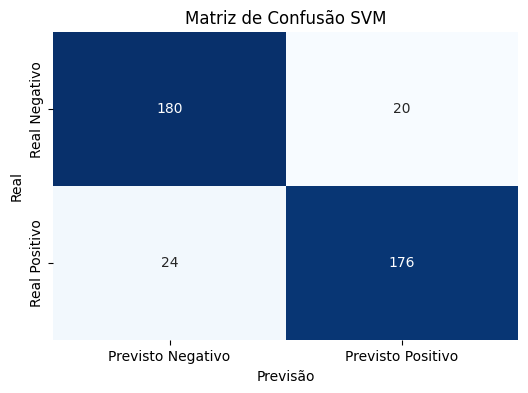

Previsão individual SVM salva em: previsoes_individuais_svm.txt

=== CARREGANDO E VISUALIZANDO RESULTADOS SVM SALVOS ===

--- PRIMEIRAS 10 LINHAS DOS RESULTADOS SVM ---


,texto_original,classe_real,classe_prevista,probabilidade_negativa,probabilidade_positiva,acertou
0,Adorei este livro para entender como funcionam...,positivo,positivo,0.271419,0.728581,True
1,Ótima aquisição. Valeu muito a pena ter compra...,positivo,positivo,0.048922,0.951078,True
2,"Olá, Recebi uma notificação por email que não ...",negativo,negativo,0.906420,0.093580,True
3,"Péssimo, um tentativa de fazer dinheiro apenas...",negativo,negativo,0.981793,0.018207,True
4,minha avalicao sobre o livro e a seguinte: e b...,negativo,negativo,0.969945,0.030055,True
5,Ótima ideia: aglutinar os livros dos quatro ir...,positivo,positivo,0.012386,0.987614,True
6,Podem me explicar do porquê deste preço pra ve...,negativo,negativo,0.969880,0.030120,True
7,O livro é excelente. Um clássico. Assim que fi...,negativo,positivo,0.405397,0.594603,False
8,Sempre o desconfiei como mais um das prateleir...,positivo,positivo,0.056743,0.943257,True
9,Amooooo essa série. Estive acompanhando desde ...,positivo,positivo,0.004554,0.995446,True



--- EXEMPLOS DE CLASSIFICAÇÕES INCORRETAS SVM ---


,texto_original,classe_real,classe_prevista,probabilidade_positiva
7,O livro é excelente. Um clássico. Assim que fi...,negativo,positivo,0.594603
17,Textos fundamentais! Uma ótima porta de entrad...,positivo,negativo,0.203477
30,"eu comecei a ler sem muita expectativa, apenas...",positivo,negativo,0.500000
35,"Lani escreve muito bem,não posso negar. Tem um...",negativo,positivo,0.610203
52,"Amei! Devorei esses livros em 15 dias, gostei...",negativo,positivo,0.927298


<Figure size 640x480 with 0 Axes>


--- CASOS COM MAIOR CONFIANÇA SVM ---
Erro ao carregar o arquivo: 'incerteza'


In [127]:
print("\n=== VETORIZAÇÃO DOS TEXTOS (TF-IDF) ===")
tfidf_vectorizer = TfidfVectorizer()

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"Vocabulário TF-IDF gerado: {len(tfidf_vectorizer.vocabulary_)} termos")
print(f"Shape dos dados de treino vetorizados (TF-IDF): {X_train_tfidf.shape}")
print(f"Shape dos dados de teste vetorizados (TF-IDF): {X_test_tfidf.shape}")

print("\n=== TREINAMENTO DO MODELO SVM ===")
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train_tfidf, y_train)
print("Modelo SVM treinado com sucesso.")

y_pred_svm = svm_model.predict(X_test_tfidf)

print("\n=== AVALIAÇÃO DO MODELO SVM ===")

accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Acurácia SVM: {accuracy_svm:.4f}")

print("\nRelatório de Classificação SVM:")
print(classification_report(y_test, y_pred_svm))

print("\nMatriz de Confusão SVM:")
cm_svm = confusion_matrix(y_test, y_pred_svm)
display(pd.DataFrame(cm_svm, index=['Real Negativo', 'Real Positivo'], columns=['Previsto Negativo', 'Previsto Positivo']))

plt.figure(figsize=(6, 4))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Previsto Negativo', 'Previsto Positivo'],
            yticklabels=['Real Negativo', 'Real Positivo'])
plt.title('Matriz de Confusão SVM')
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.show()

def salvar_classificacoes_svm(textos_originais, textos_processados, y_test, y_pred, probabilidades, nome_arquivo='classificacoes_svm.csv'):

    resultados = pd.DataFrame({
        'texto_original': textos_originais.values,
        'classe_real': y_test.values,
        'classe_prevista': y_pred,
        'probabilidade_negativa': probabilidades[:, 0],
        'probabilidade_positiva': probabilidades[:, 1],
        'acertou': y_test.values == y_pred
    })

    resultados.to_csv(nome_arquivo, index=False, encoding='utf-8')
    print(f"\nClassificações SVM salvas em: {nome_arquivo}")
    print(f"Total de registros salvos: {len(resultados)}")

    return resultados

probabilidades_teste_svm = svm_model.predict_proba(X_test_tfidf)


def salvar_previsao_individual_svm(texto_original, texto_processado, classe_prevista, probabilidades, nome_arquivo='previsoes_individuais_svm.txt'):
    """
    Salva uma previsão individual SVM em um arquivo de texto.
    """
    import datetime

    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    with open(nome_arquivo, 'a', encoding='utf-8') as f:
        f.write(f"\n{'='*50}\n")
        f.write(f"Data/Hora: {timestamp}\n")
        f.write(f"Texto Original: {texto_original}\n")
        f.write(f"Classe Prevista (SVM): {classe_prevista}\n")
        f.write(f"Probabilidade Negativa: {probabilidades[0][0]:.4f}\n")
        f.write(f"Probabilidade Positiva: {probabilidades[0][1]:.4f}\n")
        f.write(f"{'='*50}\n")

    print(f"Previsão individual SVM salva em: {nome_arquivo}")

salvar_previsao_individual_svm(novo_texto, novo_texto_stemmado, previsao_svm[0], probabilidades_svm)


print("\n=== CARREGANDO E VISUALIZANDO RESULTADOS SVM SALVOS ===")

try:
    df_resultados_svm_carregado = pd.read_csv('classificacoes_svm.csv', encoding='utf-8')

    print("\n--- PRIMEIRAS 10 LINHAS DOS RESULTADOS SVM ---")
    display(df_resultados_svm_carregado.head(10))

    print("\n--- EXEMPLOS DE CLASSIFICAÇÕES INCORRETAS SVM ---")
    erros_svm = df_resultados_svm_carregado[df_resultados_svm_carregado['acertou'] == False].head(5)
    display(erros_svm[['texto_original', 'classe_real', 'classe_prevista', 'probabilidade_positiva']])


    plt.tight_layout()
    plt.show()


    print("\n--- CASOS COM MAIOR CONFIANÇA SVM ---")
    casos_confiantes_svm = df_resultados_svm_carregado.nlargest(5, 'incerteza')
    display(casos_confiantes_svm[['texto_original', 'classe_real', 'classe_prevista',
                                 'probabilidade_positiva', 'acertou']])

except FileNotFoundError:
    print("Arquivo 'classificacoes_svm.csv' não encontrado.")
    print("Certifique-se de que o código anterior foi executado e o arquivo foi salvo.")
except Exception as e:
    print(f"Erro ao carregar o arquivo: {e}")

#Oplexicon

In [122]:
def carregar_oplexicon_correto(url_ou_arquivo):
    try:
        print("=== CARREGANDO OPLEXICON CORRETAMENTE ===")

        df_lexico = pd.read_csv(url_ou_arquivo, sep=',', header=None,
                               names=['palavra', 'tipo', 'polaridade', 'classe'])

        print(f"Total de entradas: {len(df_lexico)}")
        print("\nPrimeiras 10 entradas:")
        print(df_lexico.head(10))


        palavras_positivas = df_lexico[df_lexico['polaridade'] == 1]['palavra'].tolist()
        palavras_negativas = df_lexico[df_lexico['polaridade'] == -1]['palavra'].tolist()

        print(f"\nPalavras positivas: {len(palavras_positivas)}")
        print(f"Palavras negativas: {len(palavras_negativas)}")

        palavras_positivas = [p.lower() for p in palavras_positivas]
        palavras_negativas = [p.lower() for p in palavras_negativas]

        print(f"\nExemplos de palavras positivas: {palavras_positivas[:20]}")
        print(f"Exemplos de palavras negativas: {palavras_negativas[:20]}")

        return palavras_positivas, palavras_negativas, df_lexico

    except Exception as e:
        print(f"Erro ao carregar o léxico: {e}")
        return [], [], pd.DataFrame()

url_oplexicon = 'https://raw.githubusercontent.com/marlovss/OpLexicon/main/lexico_v3.0.txt'
lexicons_positivos, lexicons_negativos, df_lexico_completo = carregar_oplexicon_correto(url_oplexicon)

def preprocessar_texto(texto):
    """Preprocessa o texto removendo pontuação e convertendo para minúsculas"""
    texto = re.sub(r'[^\w\s]', ' ', texto.lower())
    texto = re.sub(r'\s+', ' ', texto.strip())
    return texto

def classificar_com_lexicon(texto, lexicons_positivos, lexicons_negativos):
    """
    Classifica o texto baseado na contagem de palavras positivas vs negativas
    """
    texto_processado = preprocessar_texto(texto)
    palavras = texto_processado.split()

    cont_positivo = sum(1 for palavra in palavras if palavra in lexicons_positivos)
    cont_negativo = sum(1 for palavra in palavras if palavra in lexicons_negativos)

    palavras_pos_encontradas = [p for p in palavras if p in lexicons_positivos]
    palavras_neg_encontradas = [p for p in palavras if p in lexicons_negativos]

    if cont_positivo > cont_negativo:
        classe_predita = "positivo"
    elif cont_negativo > cont_positivo:
        classe_predita = "negativo"
    else:
        classe_predita = "positivo"

    return classe_predita, cont_positivo, cont_negativo, palavras_pos_encontradas, palavras_neg_encontradas

print("=== APLICANDO AOS DADOS REAIS ===")
resultados = []

amostra = df_reviews.head(100)
print(f"Testando com amostra de {len(amostra)} reviews...")

for idx, row in amostra.iterrows():
    texto = row['review']
    classe_real = row['classe']

    classe_predita, cont_pos, cont_neg, pos_words, neg_words = classificar_com_lexicon(texto, lexicons_positivos, lexicons_negativos)

    resultados.append({
        'review': texto,
        'classe_real': classe_real,
        'classe_predita': classe_predita,
        'palavras_positivas': cont_pos,
        'palavras_negativas': cont_neg,
        'diferenca': cont_pos - cont_neg,
        'pos_words': pos_words,
        'neg_words': neg_words
    })

df_resultados_amostra = pd.DataFrame(resultados)

print(f"\nAmostra - Total de reviews: {len(df_resultados_amostra)}")
print(f"Classificados como positivos: {len(df_resultados_amostra[df_resultados_amostra['classe_predita'] == 'positivo'])}")
print(f"Classificados como negativos: {len(df_resultados_amostra[df_resultados_amostra['classe_predita'] == 'negativo'])}")

acuracia_amostra = accuracy_score(df_resultados_amostra['classe_real'], df_resultados_amostra['classe_predita'])
print(f"Acurácia da amostra: {acuracia_amostra:.2%}")

print("\n=== EXEMPLOS DETALHADOS DA AMOSTRA ===")
for idx in range(min(5, len(df_resultados_amostra))):
    row = df_resultados_amostra.iloc[idx]
    print(f"\nReview {idx+1}:")
    print(f"  Texto: {row['review'][:200]}...")
    print(f"  Classe real: {row['classe_real']}")
    print(f"  Classe predita: {row['classe_predita']}")
    print(f"  Palavras positivas ({row['palavras_positivas']}): {row['pos_words']}")
    print(f"  Palavras negativas ({row['palavras_negativas']}): {row['neg_words']}")

if acuracia_amostra > 0.4:
    print("\n=== PROCESSANDO DATASET COMPLETO ===")

    resultados_completos = []

    for idx, row in df_reviews.iterrows():
        if idx % 500 == 0:
            print(f"Processando review {idx+1}/{len(df_reviews)}")

        texto = row['review']
        classe_real = row['classe']

        classe_predita, cont_pos, cont_neg, pos_words, neg_words = classificar_com_lexicon(texto, lexicons_positivos, lexicons_negativos)

        resultados_completos.append({
            'review': texto,
            'classe_real': classe_real,
            'classe_predita': classe_predita,
            'palavras_positivas': cont_pos,
            'palavras_negativas': cont_neg,
            'diferenca': cont_pos - cont_neg
        })

    df_resultados_final = pd.DataFrame(resultados_completos)

    print(f"\nTotal de reviews: {len(df_resultados_final)}")
    print(f"Classificados como positivos: {len(df_resultados_final[df_resultados_final['classe_predita'] == 'positivo'])}")
    print(f"Classificados como negativos: {len(df_resultados_final[df_resultados_final['classe_predita'] == 'negativo'])}")

    acuracia_final = accuracy_score(df_resultados_final['classe_real'], df_resultados_final['classe_predita'])
    print(f"\nAcurácia final: {acuracia_final:.2%}")

    print("\n--- RELATÓRIO DE CLASSIFICAÇÃO ---")
    print(classification_report(df_resultados_final['classe_real'], df_resultados_final['classe_predita']))

    print("\n--- MATRIZ DE CONFUSÃO ---")
    cm = confusion_matrix(df_resultados_final['classe_real'], df_resultados_final['classe_predita'])
    print("                 Predito")
    print("                 neg  pos")
    print(f"Real negativo   {cm[0,0]:4d} {cm[0,1]:4d}")
    print(f"Real positivo   {cm[1,0]:4d} {cm[1,1]:4d}")

    df_resultados_final.to_csv('resultados_oplexicon_correto.csv', index=False, encoding='utf-8')
    print(f"\nResultados salvos em 'resultados_oplexicon_correto.csv'")

else:
    print(f"\nAcurácia da amostra muito baixa ({acuracia_amostra:.2%}). Verifique o léxico.")

=== CARREGANDO OPLEXICON CORRETAMENTE ===
Total de entradas: 32191

Primeiras 10 entradas:
  palavra  tipo  polaridade classe
0      =[  emot          -1      A
1      =@  emot          -1      A
2      =p  emot          -1      A
3      =P  emot          -1      A
4      =x  emot          -1      A
5      =d  emot           1      A
6      =D  emot           1      A
7      ;)  emot           1      A
8      ;)  emot           1      A
9      ;@  emot          -1      A

Palavras positivas: 8620
Palavras negativas: 14569

Exemplos de palavras positivas: ['=d', '=d', ';)', ';)', ':)', ':)', ':)))', ':d', ':x)', '(=', '#64bit', '#aduvirientregate', '#agendadeldia', '#agua', '#amo', '#amodoro', '#amorposmoderno', '#an', '#android', '#aqu']
Exemplos de palavras negativas: ['=[', '=@', '=p', '=p', '=x', ';@', ';*', ';**', ';~', ';d', ';d', ';p', ';p', ';p', ';x', ';xx', ":'(", ":')", ':(', ':(']
=== APLICANDO AOS DADOS REAIS ===
Testando com amostra de 100 reviews...

Amostra - Total de re

# Wordnet Affect BR

In [123]:
def carregar_wordnet_affect_br(arquivo_csv):
    try:
        print("=== CARREGANDO WORDNET AFFECT BR ===")

        df_lexico = pd.read_csv(arquivo_csv, sep=';', encoding='cp1252')

        print(f"Total de entradas: {len(df_lexico)}")
        print("\nColunas encontradas:")
        print(df_lexico.columns.tolist())
        print("\nPrimeiras 10 entradas:")
        print(df_lexico.head(10))

        palavras_positivas = []
        palavras_negativas = []

        for idx, row in df_lexico.iterrows():
            palavra = str(row['Wordnet Affect BR']).strip().lower()
            valencia = str(row['Valência']).strip()

            if valencia == '+':
                palavras_positivas.append(palavra)
            elif valencia == '-':
                palavras_negativas.append(palavra)

        print(f"\nPalavras positivas: {len(palavras_positivas)}")
        print(f"Palavras negativas: {len(palavras_negativas)}")

        print(f"\nExemplos de palavras positivas: {palavras_positivas[:20]}")
        print(f"Exemplos de palavras negativas: {palavras_negativas[:20]}")

        return palavras_positivas, palavras_negativas, df_lexico

    except Exception as e:
        print(f"Erro ao carregar o léxico: {e}")
        print("Tentando formato alternativo...")

        try:
            df_lexico = pd.read_csv(arquivo_csv, encoding='cp1252')
            print("Estrutura do arquivo:")
            print(df_lexico.head())
            print("Colunas:", df_lexico.columns.tolist())

            if len(df_lexico.columns) == 1:
                primeira_coluna = df_lexico.columns[0]
                if ';' in primeira_coluna:
                    df_lexico = pd.read_csv(arquivo_csv, sep=';', encoding='cp1252')
                    print("Recarregado com separador ';'")
                    print(df_lexico.head())

            return [], [], df_lexico

        except Exception as e2:
            print(f"Erro adicional: {e2}")
            return [], [], pd.DataFrame()

lexicons_positivos, lexicons_negativos, df_lexico_completo = carregar_wordnet_affect_br('wordnetaffectbr_valencia.csv')

def preprocessar_texto(texto):
    """Preprocessa o texto removendo pontuação e convertendo para minúsculas"""
    texto = re.sub(r'[^\w\s]', ' ', texto.lower())
    texto = re.sub(r'\s+', ' ', texto.strip())
    return texto

def classificar_com_lexicon(texto, lexicons_positivos, lexicons_negativos):
    """
    Classifica o texto baseado na contagem de palavras positivas vs negativas
    """
    texto_processado = preprocessar_texto(texto)
    palavras = texto_processado.split()

    cont_positivo = sum(1 for palavra in palavras if palavra in lexicons_positivos)
    cont_negativo = sum(1 for palavra in palavras if palavra in lexicons_negativos)

    palavras_pos_encontradas = [p for p in palavras if p in lexicons_positivos]
    palavras_neg_encontradas = [p for p in palavras if p in lexicons_negativos]

    if cont_positivo > cont_negativo:
        classe_predita = "positivo"
    elif cont_negativo > cont_positivo:
        classe_predita = "negativo"
    else:
        classe_predita = "positivo"

    return classe_predita, cont_positivo, cont_negativo, palavras_pos_encontradas, palavras_neg_encontradas

if len(lexicons_positivos) == 0 and len(lexicons_negativos) == 0:
    print("\n!!! ATENÇÃO: Nenhuma palavra foi carregada do léxico !!!")
    print("Verificando estrutura do arquivo...")

    try:
        import pandas as pd
        df_test = pd.read_csv('wordnetaffectbr_valencia.csv', encoding='cp1252')
        print("Estrutura encontrada:")
        print(df_test.head())
        print("Colunas:", df_test.columns.tolist())
        print("Tipos de dados:", df_test.dtypes)

        palavras_pos_manual = []
        palavras_neg_manual = []

        for idx, row in df_test.iterrows():
            if 'Wordnet Affect BR' in df_test.columns and 'Valência' in df_test.columns:
                palavra = str(row['Wordnet Affect BR']).strip().lower()
                valencia = str(row['Valência']).strip()

                if valencia == '+':
                    palavras_pos_manual.append(palavra)
                elif valencia == '-':
                    palavras_neg_manual.append(palavra)

        print(f"\nReprocessamento manual:")
        print(f"Palavras positivas: {len(palavras_pos_manual)}")
        print(f"Palavras negativas: {len(palavras_neg_manual)}")

        if len(palavras_pos_manual) > 0 or len(palavras_neg_manual) > 0:
            lexicons_positivos = palavras_pos_manual
            lexicons_negativos = palavras_neg_manual
            print("Léxico carregado com sucesso!")

    except Exception as e:
        print(f"Erro na análise manual: {e}")

print("\n=== TESTANDO COM EXEMPLOS ===")
exemplos_teste = [
    "Este livro é ótimo e maravilhoso!",
    "Que história terrível e péssima.",
    "Adorei este livro, é fantástico!",
    "Não gostei nada, muito chato e ruim.",
    "O livro é bom mas tem alguns problemas.",
    "História interessante, recomendo!",
    "Livro abominável e terrível.",
    "Sinto admiração por este livro.",
    "Estou abatido com esta leitura.",
    "Que maravilha admirável!"
]

for texto in exemplos_teste:
    classe_pred, pos_count, neg_count, pos_words, neg_words = classificar_com_lexicon(texto, lexicons_positivos, lexicons_negativos)
    print(f"Texto: {texto}")
    print(f"  Positivas: {pos_count} {pos_words}")
    print(f"  Negativas: {neg_count} {neg_words}")
    print(f"  Classe: {classe_pred}")
    print()

if len(lexicons_positivos) > 0 or len(lexicons_negativos) > 0:
    print("=== APLICANDO AOS DADOS REAIS ===")
    resultados = []

    amostra = df_reviews.head(100)
    print(f"Testando com amostra de {len(amostra)} reviews...")

    for idx, row in amostra.iterrows():
        texto = row['review']
        classe_real = row['classe']

        classe_predita, cont_pos, cont_neg, pos_words, neg_words = classificar_com_lexicon(texto, lexicons_positivos, lexicons_negativos)

        resultados.append({
            'review': texto,
            'classe_real': classe_real,
            'classe_predita': classe_predita,
            'palavras_positivas': cont_pos,
            'palavras_negativas': cont_neg,
            'diferenca': cont_pos - cont_neg,
            'pos_words': pos_words,
            'neg_words': neg_words
        })

    df_resultados_amostra = pd.DataFrame(resultados)

    print(f"\nAmostra - Total de reviews: {len(df_resultados_amostra)}")
    print(f"Classificados como positivos: {len(df_resultados_amostra[df_resultados_amostra['classe_predita'] == 'positivo'])}")
    print(f"Classificados como negativos: {len(df_resultados_amostra[df_resultados_amostra['classe_predita'] == 'negativo'])}")

    acuracia_amostra = accuracy_score(df_resultados_amostra['classe_real'], df_resultados_amostra['classe_predita'])
    print(f"Acurácia da amostra: {acuracia_amostra:.2%}")

    print("\n=== EXEMPLOS DETALHADOS DA AMOSTRA ===")
    for idx in range(min(5, len(df_resultados_amostra))):
        row = df_resultados_amostra.iloc[idx]
        print(f"\nReview {idx+1}:")
        print(f"  Texto: {row['review'][:200]}...")
        print(f"  Classe real: {row['classe_real']}")
        print(f"  Classe predita: {row['classe_predita']}")
        print(f"  Palavras positivas ({row['palavras_positivas']}): {row['pos_words']}")
        print(f"  Palavras negativas ({row['palavras_negativas']}): {row['neg_words']}")

    if acuracia_amostra > 0.3:
        print("\n=== PROCESSANDO DATASET COMPLETO ===")

        resultados_completos = []

        for idx, row in df_reviews.iterrows():
            if idx % 500 == 0:
                print(f"Processando review {idx+1}/{len(df_reviews)}")

            texto = row['review']
            classe_real = row['classe']

            classe_predita, cont_pos, cont_neg, pos_words, neg_words = classificar_com_lexicon(texto, lexicons_positivos, lexicons_negativos)

            resultados_completos.append({
                'review': texto,
                'classe_real': classe_real,
                'classe_predita': classe_predita,
                'palavras_positivas': cont_pos,
                'palavras_negativas': cont_neg,
                'diferenca': cont_pos - cont_neg
            })

        df_resultados_final = pd.DataFrame(resultados_completos)

        print(f"\nTotal de reviews: {len(df_resultados_final)}")
        print(f"Classificados como positivos: {len(df_resultados_final[df_resultados_final['classe_predita'] == 'positivo'])}")
        print(f"Classificados como negativos: {len(df_resultados_final[df_resultados_final['classe_predita'] == 'negativo'])}")

        acuracia_final = accuracy_score(df_resultados_final['classe_real'], df_resultados_final['classe_predita'])
        print(f"\nAcurácia final: {acuracia_final:.2%}")

        print("\n--- RELATÓRIO DE CLASSIFICAÇÃO ---")
        print(classification_report(df_resultados_final['classe_real'], df_resultados_final['classe_predita']))

        print("\n--- MATRIZ DE CONFUSÃO ---")
        cm = confusion_matrix(df_resultados_final['classe_real'], df_resultados_final['classe_predita'])
        print("                 Predito")
        print("                 neg  pos")
        print(f"Real negativo   {cm[0,0]:4d} {cm[0,1]:4d}")
        print(f"Real positivo   {cm[1,0]:4d} {cm[1,1]:4d}")

        df_resultados_final.to_csv('resultados_wordnet_affect_br.csv', index=False, encoding='utf-8')
        print(f"\nResultados salvos em 'resultados_wordnet_affect_br.csv'")

    else:
        print(f"\nAcurácia da amostra muito baixa ({acuracia_amostra:.2%}). Verifique o léxico.")

else:
    print("ERRO: Não foi possível carregar o léxico. Verifique o arquivo.")

=== CARREGANDO WORDNET AFFECT BR ===
Total de entradas: 289

Colunas encontradas:
['Wordnet Affect BR', 'Valência']

Primeiras 10 entradas:
  Wordnet Affect BR Valência
0           abalado        -
1           abatido        -
2        abominação        -
3      abrandamento        +
4          acanhado        -
5       acanhamento        -
6       acrimonioso        -
7         admiração        +
8          admirado        +
9         admirável        +

Palavras positivas: 116
Palavras negativas: 173

Exemplos de palavras positivas: ['abrandamento', 'admiração', 'admirado', 'admirável', 'adorável', 'afeição', 'afeiçoado', 'afetuoso', 'afortunado', 'agradável', 'agradecido', 'ajuda', 'alegre', 'alegria', 'aliviado', 'alívio', 'altivo', 'amado', 'amável', 'amor']
Exemplos de palavras negativas: ['abalado', 'abatido', 'abominação', 'acanhado', 'acanhamento', 'acrimonioso', 'adversidade', 'aflição', 'aflito', 'agonia', 'agoniado', 'agonizante', 'alarmante', 'alegria pelo mau alheio', 'am

# Sentilex

In [124]:
def remove_acentos(texto):
    """Remove acentos de uma string"""
    import unicodedata
    return ''.join(c for c in unicodedata.normalize('NFD', texto) if unicodedata.category(c) != 'Mn')

def carregar_sentilex(arquivo):
    """
    Carrega o léxico SentiLex e processa as entradas
    Formato: palavra.PoS=Tipo;TG=...;POL:N0=valor;ANOT=...
    """
    try:
        lexicon_data = []

        with open(arquivo, 'r', encoding='utf-8') as f:
            for linha in f:
                linha = linha.strip()
                if linha:
                    palavra = linha.split('.')[0]

                    pol_match = re.search(r'POL:N0=(-?\d+)', linha)
                    if pol_match:
                        polaridade = int(pol_match.group(1))
                        lexicon_data.append({
                            'palavra': palavra,
                            'polaridade': polaridade,
                            'linha_original': linha
                        })

        df_lexico = pd.DataFrame(lexicon_data)
        return df_lexico

    except Exception as e:
        print(f"Erro ao carregar o léxico: {e}")
        return pd.DataFrame()

arquivo_sentilex = 'SentiLex-lem-PT02.txt'
df_lexico = carregar_sentilex(arquivo_sentilex)

print(f"Léxico SentiLex carregado com {len(df_lexico)} palavras")

if not df_lexico.empty:
    df_lexico['palavra'] = df_lexico['palavra'].apply(remove_acentos)

    lexicons_positivos = df_lexico[df_lexico['polaridade'] > 0]['palavra'].tolist()
    lexicons_negativos = df_lexico[df_lexico['polaridade'] < 0]['palavra'].tolist()
    lexicons_neutros = df_lexico[df_lexico['polaridade'] == 0]['palavra'].tolist()

    print(f"Palavras positivas: {len(lexicons_positivos)}")
    print(f"Palavras negativas: {len(lexicons_negativos)}")
    print(f"Palavras neutras: {len(lexicons_neutros)}")

    print(f"\nExemplos de palavras positivas: {lexicons_positivos[:10]}")
    print(f"Exemplos de palavras negativas: {lexicons_negativos[:10]}")

    print(f"\nDistribuição de polaridades:")
    print(df_lexico['polaridade'].value_counts().sort_index())

def preprocessar_texto(texto):
    """Preprocessa o texto removendo pontuação e convertendo para minúsculas"""
    texto = re.sub(r'[^\w\s]', ' ', texto.lower())
    texto = re.sub(r'\s+', ' ', texto.strip())
    return texto

def classificar_com_lexicon(texto, lexicons_positivos, lexicons_negativos):
    """
    Classifica o texto baseado na contagem de palavras positivas vs negativas
    """
    texto_processado = preprocessar_texto(texto)
    palavras = [remove_acentos(palavra) for palavra in texto_processado.split()]

    cont_positivo = sum(1 for palavra in palavras if palavra in lexicons_positivos)
    cont_negativo = sum(1 for palavra in palavras if palavra in lexicons_negativos)

    if cont_positivo > cont_negativo:
        classe_predita = "positivo"
    elif cont_negativo > cont_positivo:
        classe_predita = "negativo"
    else:
        classe_predita = "positivo"

    return classe_predita, cont_positivo, cont_negativo

print("\n--- APLICANDO CLASSIFICAÇÃO ---")

resultados = []
for idx, row in df_reviews.iterrows():
    texto = row['review']
    classe_real = row['classe']

    classe_predita, cont_pos, cont_neg = classificar_com_lexicon(texto, lexicons_positivos, lexicons_negativos)

    resultados.append({
        'review': texto,
        'classe_real': classe_real,
        'classe_predita': classe_predita,
        'palavras_positivas': cont_pos,
        'palavras_negativas': cont_neg,
        'diferenca': cont_pos - cont_neg
    })

df_resultados = pd.DataFrame(resultados)

print(f"\nTotal de reviews: {len(df_resultados)}")
print(f"Classificados como positivos: {len(df_resultados[df_resultados['classe_predita'] == 'positivo'])}")
print(f"Classificados como negativos: {len(df_resultados[df_resultados['classe_predita'] == 'negativo'])}")

acuracia = accuracy_score(df_resultados['classe_real'], df_resultados['classe_predita'])
print(f"\nAcurácia: {acuracia:.2%}")

print("\n--- ANÁLISE DAS CONTAGENS ---")
print(f"Reviews com mais palavras positivas: {len(df_resultados[df_resultados['diferenca'] > 0])}")
print(f"Reviews com mais palavras negativas: {len(df_resultados[df_resultados['diferenca'] < 0])}")
print(f"Reviews com empate: {len(df_resultados[df_resultados['diferenca'] == 0])}")

print("\n--- ESTATÍSTICAS POR CLASSE REAL ---")
for classe in ['positivo', 'negativo']:
    subset = df_resultados[df_resultados['classe_real'] == classe]
    print(f"\nClasse {classe}:")
    print(f"  Média de palavras positivas: {subset['palavras_positivas'].mean():.2f}")
    print(f"  Média de palavras negativas: {subset['palavras_negativas'].mean():.2f}")
    print(f"  Média da diferença: {subset['diferenca'].mean():.2f}")

print("\n--- EXEMPLOS DE CLASSIFICAÇÃO ---")
exemplos = df_resultados[['review', 'classe_real', 'classe_predita', 'palavras_positivas', 'palavras_negativas', 'diferenca']].head(10)
for col in exemplos.columns:
    if col == 'review':
        exemplos[col] = exemplos[col].str[:50] + "..."
display(exemplos)

print("\n--- RELATÓRIO DE CLASSIFICAÇÃO ---")
report = classification_report(df_resultados['classe_real'], df_resultados['classe_predita'])
print(report)

print("\n--- MATRIZ DE CONFUSÃO ---")
cm = confusion_matrix(df_resultados['classe_real'], df_resultados['classe_predita'])
print("                 Predito")
print("                 neg  pos")
print(f"Real negativo   {cm[0,0]:4d} {cm[0,1]:4d}")
print(f"Real positivo   {cm[1,0]:4d} {cm[1,1]:4d}")

print("\n--- CASOS EXTREMOS ---")
print("Reviews com mais palavras positivas:")
top_positivos = df_resultados.nlargest(3, 'palavras_positivas')[['review', 'classe_real', 'palavras_positivas', 'palavras_negativas']]
for _, row in top_positivos.iterrows():
    print(f"  {row['review'][:100]}... (Real: {row['classe_real']}, Pos: {row['palavras_positivas']}, Neg: {row['palavras_negativas']})")

print("\nReviews com mais palavras negativas:")
top_negativos = df_resultados.nlargest(3, 'palavras_negativas')[['review', 'classe_real', 'palavras_positivas', 'palavras_negativas']]
for _, row in top_negativos.iterrows():
    print(f"  {row['review'][:100]}... (Real: {row['classe_real']}, Pos: {row['palavras_positivas']}, Neg: {row['palavras_negativas']})")

df_resultados.to_csv('resultados_sentilex_contagem.csv', index=False, encoding='utf-8')
print(f"\nResultados salvos em 'resultados_sentilex_contagem.csv'")

Léxico SentiLex carregado com 7008 palavras
Palavras positivas: 1550
Palavras negativas: 4598
Palavras neutras: 860

Exemplos de palavras positivas: ['a-vontade', 'abalizado', 'abalroar', 'abanar', 'abastado', 'abater', 'abencoado', 'aberto', 'abnegado', 'abonado']
Exemplos de palavras negativas: ['abafado', 'abafante', 'abaixado', 'abalado', 'abalroado', 'abandalhado', 'abandalhamento', 'abandonado', 'abandonar', 'abarrotado']

Distribuição de polaridades:
polaridade
-3       1
-2       1
-1    4596
 0     860
 1    1548
 7       1
 8       1
Name: count, dtype: int64

--- APLICANDO CLASSIFICAÇÃO ---

Total de reviews: 1999
Classificados como positivos: 1468
Classificados como negativos: 531

Acurácia: 67.98%

--- ANÁLISE DAS CONTAGENS ---
Reviews com mais palavras positivas: 920
Reviews com mais palavras negativas: 531
Reviews com empate: 548

--- ESTATÍSTICAS POR CLASSE REAL ---

Classe positivo:
  Média de palavras positivas: 2.10
  Média de palavras negativas: 0.77
  Média da dife

,review,classe_real,classe_predita,palavras_positivas,palavras_negativas,diferenca
0,Enfim o final da série chegou e me deixou arre...,positivo,positivo,4,0,4
1,Aiai! Agora ficamos órfãos dos Lafaiete 😔 A hi...,positivo,positivo,4,1,3
2,"Lara smithe fechou a série com chave de ouro,q...",positivo,positivo,2,0,2
3,Mais uma vez a Lara Smithe nos deixa de boca a...,positivo,positivo,2,1,1
4,Ótima ideia: aglutinar os livros dos quatro ir...,positivo,positivo,0,0,0
5,Como sempre Lara Smithe nos cativa com Mauríci...,positivo,positivo,0,0,0
6,Maurício o cara romântico lindo que corre atrá...,positivo,positivo,1,0,1
7,Não sei como explicar o quanto esse livro é ma...,positivo,positivo,6,1,5
8,Que história maravilhosa! Que personagens hilá...,positivo,positivo,5,1,4
9,Aah o que dizer desse livro 😍😍 sou completamen...,positivo,positivo,1,1,0



--- RELATÓRIO DE CLASSIFICAÇÃO ---
              precision    recall  f1-score   support

    negativo       0.84      0.45      0.58       999
    positivo       0.62      0.91      0.74      1000

    accuracy                           0.68      1999
   macro avg       0.73      0.68      0.66      1999
weighted avg       0.73      0.68      0.66      1999


--- MATRIZ DE CONFUSÃO ---
                 Predito
                 neg  pos
Real negativo    445  554
Real positivo     86  914

--- CASOS EXTREMOS ---
Reviews com mais palavras positivas:
  Conforme o próprio autor, T. Harv Eker começa seu livro: "as histórias apresentadas no livro não são... (Real: positivo, Pos: 34, Neg: 32)
  Crime e Castigo. Um dos grandes clássicos da Literatura Universal. Inúmeras teses, resenhas e anális... (Real: positivo, Pos: 18, Neg: 7)
  Qual é a melhor versão em português de “A Divina Comédia”? Abaixo, comparei o início do Canto I (Inf... (Real: positivo, Pos: 17, Neg: 35)

Reviews com mais palav

# LIWC

In [125]:
def remove_acentos(texto):
    """Remove acentos de uma string"""
    import unicodedata
    return ''.join(c for c in unicodedata.normalize('NFD', texto) if unicodedata.category(c) != 'Mn')

def carregar_liwc(arquivo):
    """
    Carrega o léxico LIWC e processa as entradas
    Formato: palavra<tab>código1<tab>código2...
    """
    try:
        categorias = {}
        palavras_data = []

        with open(arquivo, 'r', encoding='utf-8') as f:
            linhas = f.readlines()

        lendo_categorias = True
        for linha in linhas:
            linha = linha.strip()
            if linha == '%':
                lendo_categorias = False
                continue

            if lendo_categorias and linha:
                partes = linha.split('\t')
                if len(partes) >= 2:
                    numero = partes[0]
                    nome = partes[1]
                    categorias[numero] = nome
            elif not lendo_categorias and linha:
                partes = linha.split('\t')
                if len(partes) >= 2:
                    palavra = partes[0]
                    codigos = partes[1:]

                    tem_posemo = '126' in codigos
                    tem_negemo = '127' in codigos

                    if tem_posemo or tem_negemo:
                        palavras_data.append({
                            'palavra': palavra,
                            'codigos': codigos,
                            'posemo': tem_posemo,
                            'negemo': tem_negemo
                        })

        df_lexico = pd.DataFrame(palavras_data)

        print(f"Categorias encontradas: {len(categorias)}")
        print("Principais categorias emocionais:")
        for codigo, nome in categorias.items():
            if codigo in ['125', '126', '127', '128', '129', '130']:
                print(f"  {codigo}: {nome}")

        return df_lexico, categorias

    except Exception as e:
        print(f"Erro ao carregar o léxico: {e}")
        return pd.DataFrame(), {}

arquivo_liwc = 'LIWC2007_Portugues_win.dic.txt'
df_lexico, categorias_liwc = carregar_liwc(arquivo_liwc)

print(f"\nLéxico LIWC carregado com {len(df_lexico)} palavras emocionais")

if not df_lexico.empty:
    df_lexico['palavra_processada'] = df_lexico['palavra'].apply(lambda x: remove_acentos(x.lower()))

    lexicons_positivos = df_lexico[df_lexico['posemo'] == True]['palavra_processada'].tolist()
    lexicons_negativos = df_lexico[df_lexico['negemo'] == True]['palavra_processada'].tolist()

    print(f"Palavras com emoção positiva (posemo): {len(lexicons_positivos)}")
    print(f"Palavras com emoção negativa (negemo): {len(lexicons_negativos)}")

    exemplos_pos = [p for p in lexicons_positivos if not '*' in p][:10]
    exemplos_neg = [p for p in lexicons_negativos if not '*' in p][:10]

    print(f"\nExemplos de palavras positivas: {exemplos_pos}")
    print(f"Exemplos de palavras negativas: {exemplos_neg}")

# Função para processar wildcards do LIWC
def processar_wildcards_liwc(palavra_liwc, palavra_texto):
    """
    Verifica se uma palavra do texto corresponde a um padrão LIWC com wildcard
    """
    if '*' in palavra_liwc:
        # Remove o * e verifica se a palavra do texto começa com o prefixo
        prefixo = palavra_liwc.replace('*', '')
        return palavra_texto.startswith(prefixo)
    else:
        return palavra_liwc == palavra_texto

# Função de preprocessamento
def preprocessar_texto(texto):
    """Preprocessa o texto removendo pontuação e convertendo para minúsculas"""
    texto = re.sub(r'[^\w\s]', ' ', texto.lower())
    texto = re.sub(r'\s+', ' ', texto.strip())
    return texto

# Função de classificação adaptada para LIWC
def classificar_com_liwc(texto, lexicons_positivos, lexicons_negativos):
    """
    Classifica o texto baseado nas palavras emocionais do LIWC
    """
    # Preprocessa o texto e remove acentos
    texto_processado = preprocessar_texto(texto)
    palavras = [remove_acentos(palavra) for palavra in texto_processado.split()]

    # Conta palavras positivas e negativas (considerando wildcards)
    cont_positivo = 0
    cont_negativo = 0

    for palavra in palavras:
        # Verifica palavras positivas
        for palavra_pos in lexicons_positivos:
            if processar_wildcards_liwc(palavra_pos, palavra):
                cont_positivo += 1
                break

        # Verifica palavras negativas
        for palavra_neg in lexicons_negativos:
            if processar_wildcards_liwc(palavra_neg, palavra):
                cont_negativo += 1
                break

    # Classifica com base na contagem
    if cont_positivo > cont_negativo:
        classe_predita = "positivo"
    elif cont_negativo > cont_positivo:
        classe_predita = "negativo"
    else:
        # Em caso de empate, classifica como positivo
        classe_predita = "positivo"

    return classe_predita, cont_positivo, cont_negativo

# Aplica a classificação
print("\n--- APLICANDO CLASSIFICAÇÃO ---")

resultados = []
for idx, row in df_reviews.iterrows():
    if idx % 500 == 0:
        print(f"Processando review {idx+1}/{len(df_reviews)}")

    texto = row['review']
    classe_real = row['classe']

    classe_predita, cont_pos, cont_neg = classificar_com_liwc(texto, lexicons_positivos, lexicons_negativos)

    resultados.append({
        'review': texto,
        'classe_real': classe_real,
        'classe_predita': classe_predita,
        'palavras_positivas': cont_pos,
        'palavras_negativas': cont_neg,
        'diferenca': cont_pos - cont_neg
    })

df_resultados = pd.DataFrame(resultados)

print(f"\nTotal de reviews: {len(df_resultados)}")
print(f"Classificados como positivos: {len(df_resultados[df_resultados['classe_predita'] == 'positivo'])}")
print(f"Classificados como negativos: {len(df_resultados[df_resultados['classe_predita'] == 'negativo'])}")

acuracia = accuracy_score(df_resultados['classe_real'], df_resultados['classe_predita'])
print(f"\nAcurácia: {acuracia:.2%}")

print("\n--- ANÁLISE DAS CONTAGENS ---")
print(f"Reviews com mais palavras positivas: {len(df_resultados[df_resultados['diferenca'] > 0])}")
print(f"Reviews com mais palavras negativas: {len(df_resultados[df_resultados['diferenca'] < 0])}")
print(f"Reviews com empate: {len(df_resultados[df_resultados['diferenca'] == 0])}")

print("\n--- ESTATÍSTICAS POR CLASSE REAL ---")
for classe in ['positivo', 'negativo']:
    subset = df_resultados[df_resultados['classe_real'] == classe]
    print(f"\nClasse {classe}:")
    print(f"  Média de palavras positivas: {subset['palavras_positivas'].mean():.2f}")
    print(f"  Média de palavras negativas: {subset['palavras_negativas'].mean():.2f}")
    print(f"  Média da diferença: {subset['diferenca'].mean():.2f}")

print("\n--- EXEMPLOS DE CLASSIFICAÇÃO ---")
exemplos = df_resultados[['review', 'classe_real', 'classe_predita', 'palavras_positivas', 'palavras_negativas', 'diferenca']].head(10)
exemplos_display = exemplos.copy()
exemplos_display['review'] = exemplos_display['review'].str[:50] + "..."
display(exemplos_display)

print("\n--- RELATÓRIO DE CLASSIFICAÇÃO ---")
report = classification_report(df_resultados['classe_real'], df_resultados['classe_predita'])
print(report)

print("\n--- MATRIZ DE CONFUSÃO ---")
cm = confusion_matrix(df_resultados['classe_real'], df_resultados['classe_predita'])
print("                 Predito")
print("                 neg  pos")
print(f"Real negativo   {cm[0,0]:4d} {cm[0,1]:4d}")
print(f"Real positivo   {cm[1,0]:4d} {cm[1,1]:4d}")

print("\n--- CASOS EXTREMOS ---")
print("Reviews com mais palavras positivas:")
top_positivos = df_resultados.nlargest(3, 'palavras_positivas')[['review', 'classe_real', 'palavras_positivas', 'palavras_negativas']]
for _, row in top_positivos.iterrows():
    print(f"  {row['review'][:100]}... (Real: {row['classe_real']}, Pos: {row['palavras_positivas']}, Neg: {row['palavras_negativas']})")

print("\nReviews com mais palavras negativas:")
top_negativos = df_resultados.nlargest(3, 'palavras_negativas')[['review', 'classe_real', 'palavras_positivas', 'palavras_negativas']]
for _, row in top_negativos.iterrows():
    print(f"  {row['review'][:100]}... (Real: {row['classe_real']}, Pos: {row['palavras_positivas']}, Neg: {row['palavras_negativas']})")

df_resultados.to_csv('resultados_liwc_contagem.csv', index=False, encoding='utf-8')
print(f"\nResultados salvos em 'resultados_liwc_contagem.csv'")

print("\n--- INFORMAÇÕES SOBRE O LIWC ---")
print("Categorias principais utilizadas:")
print("  126 (posemo): Emoção positiva")
print("  127 (negemo): Emoção negativa")
print(f"Total de palavras com wildcards: {len([p for p in lexicons_positivos + lexicons_negativos if '*' in p])}")

Erro ao carregar o léxico: 'utf-8' codec can't decode byte 0xe1 in position 1299: invalid continuation byte

Léxico LIWC carregado com 0 palavras emocionais

--- APLICANDO CLASSIFICAÇÃO ---
Processando review 1/1999
Processando review 501/1999
Processando review 1001/1999
Processando review 1501/1999

Total de reviews: 1999
Classificados como positivos: 1468
Classificados como negativos: 531

Acurácia: 67.98%

--- ANÁLISE DAS CONTAGENS ---
Reviews com mais palavras positivas: 920
Reviews com mais palavras negativas: 531
Reviews com empate: 548

--- ESTATÍSTICAS POR CLASSE REAL ---

Classe positivo:
  Média de palavras positivas: 2.10
  Média de palavras negativas: 0.77
  Média da diferença: 1.33

Classe negativo:
  Média de palavras positivas: 0.94
  Média de palavras negativas: 1.39
  Média da diferença: -0.44

--- EXEMPLOS DE CLASSIFICAÇÃO ---


,review,classe_real,classe_predita,palavras_positivas,palavras_negativas,diferenca
0,Enfim o final da série chegou e me deixou arre...,positivo,positivo,4,0,4
1,Aiai! Agora ficamos órfãos dos Lafaiete 😔 A hi...,positivo,positivo,4,1,3
2,"Lara smithe fechou a série com chave de ouro,q...",positivo,positivo,2,0,2
3,Mais uma vez a Lara Smithe nos deixa de boca a...,positivo,positivo,2,1,1
4,Ótima ideia: aglutinar os livros dos quatro ir...,positivo,positivo,0,0,0
5,Como sempre Lara Smithe nos cativa com Mauríci...,positivo,positivo,0,0,0
6,Maurício o cara romântico lindo que corre atrá...,positivo,positivo,1,0,1
7,Não sei como explicar o quanto esse livro é ma...,positivo,positivo,6,1,5
8,Que história maravilhosa! Que personagens hilá...,positivo,positivo,5,1,4
9,Aah o que dizer desse livro 😍😍 sou completamen...,positivo,positivo,1,1,0



--- RELATÓRIO DE CLASSIFICAÇÃO ---
              precision    recall  f1-score   support

    negativo       0.84      0.45      0.58       999
    positivo       0.62      0.91      0.74      1000

    accuracy                           0.68      1999
   macro avg       0.73      0.68      0.66      1999
weighted avg       0.73      0.68      0.66      1999


--- MATRIZ DE CONFUSÃO ---
                 Predito
                 neg  pos
Real negativo    445  554
Real positivo     86  914

--- CASOS EXTREMOS ---
Reviews com mais palavras positivas:
  Conforme o próprio autor, T. Harv Eker começa seu livro: "as histórias apresentadas no livro não são... (Real: positivo, Pos: 34, Neg: 32)
  Crime e Castigo. Um dos grandes clássicos da Literatura Universal. Inúmeras teses, resenhas e anális... (Real: positivo, Pos: 18, Neg: 7)
  Qual é a melhor versão em português de “A Divina Comédia”? Abaixo, comparei o início do Canto I (Inf... (Real: positivo, Pos: 17, Neg: 35)

Reviews com mais palav

# Affect PT-BR

In [126]:
def carregar_affect_pt_br(arquivo_txt):
    try:
        print("=== CARREGANDO AFFECTPT-BR ===")

        palavras_positivas = []
        palavras_negativas = []
        todas_palavras = []

        with open(arquivo_txt, 'r', encoding='utf-8') as f:
            linhas = f.readlines()

        for linha in linhas:
            linha = linha.strip()

            if not linha or linha.startswith('%'):
                continue

            partes = linha.split('\t')
            if len(partes) < 2:
                continue

            palavra = partes[0].strip()
            categorias = [cat.strip() for cat in partes[1:] if cat.strip()]

            palavra_limpa = palavra.replace('*', '')

            tem_positivo = '31' in categorias
            tem_negativo = any(cat in categorias for cat in ['32', '33', '34', '35'])

            if tem_positivo and not tem_negativo:
                palavras_positivas.append(palavra_limpa.lower())
            elif tem_negativo and not tem_positivo:
                palavras_negativas.append(palavra_limpa.lower())
            elif tem_positivo and tem_negativo:
                palavras_positivas.append(palavra_limpa.lower())
                palavras_negativas.append(palavra_limpa.lower())

            todas_palavras.append({
                'palavra': palavra,
                'palavra_limpa': palavra_limpa.lower(),
                'categorias': categorias,
                'positivo': tem_positivo,
                'negativo': tem_negativo
            })

        palavras_positivas = list(set(palavras_positivas))
        palavras_negativas = list(set(palavras_negativas))

        print(f"Total de entradas processadas: {len(todas_palavras)}")
        print(f"Palavras positivas: {len(palavras_positivas)}")
        print(f"Palavras negativas: {len(palavras_negativas)}")

        print(f"\nExemplos de palavras positivas: {palavras_positivas[:20]}")
        print(f"Exemplos de palavras negativas: {palavras_negativas[:20]}")

        df_lexico = pd.DataFrame(todas_palavras)

        return palavras_positivas, palavras_negativas, df_lexico

    except Exception as e:
        print(f"Erro ao carregar o léxico: {e}")
        return [], [], pd.DataFrame()

lexicons_positivos, lexicons_negativos, df_lexico_completo = carregar_affect_pt_br('AffectPT-br.txt')

def preprocessar_texto(texto):
    """Preprocessa o texto removendo pontuação e convertendo para minúsculas"""
    texto = re.sub(r'[^\w\s]', ' ', texto.lower())
    texto = re.sub(r'\s+', ' ', texto.strip())
    return texto

def classificar_com_lexicon_affect(texto, lexicons_positivos, lexicons_negativos):

    texto_processado = preprocessar_texto(texto)
    palavras = texto_processado.split()

    negacoes = ['não', 'nao', 'nunca', 'jamais', 'nada', 'nem', 'nenhum', 'nenhuma']

    cont_positivo = 0
    cont_negativo = 0
    palavras_pos_encontradas = []
    palavras_neg_encontradas = []

    for i, palavra in enumerate(palavras):
        negacao_presente = False
        for j in range(max(0, i-2), i):
            if palavras[j] in negacoes:
                negacao_presente = True
                break

        palavra_encontrada = False

        if palavra in lexicons_positivos:
            if negacao_presente:
                cont_negativo += 1
                palavras_neg_encontradas.append(f"NOT_{palavra}")
            else:
                cont_positivo += 1
                palavras_pos_encontradas.append(palavra)
            palavra_encontrada = True

        elif palavra in lexicons_negativos:
            if negacao_presente:
                cont_positivo += 1
                palavras_pos_encontradas.append(f"NOT_{palavra}")
            else:
                cont_negativo += 1
                palavras_neg_encontradas.append(palavra)
            palavra_encontrada = True

        if not palavra_encontrada:
            for lex_word in lexicons_positivos:
                if palavra.startswith(lex_word) and len(lex_word) >= 3:
                    if negacao_presente:
                        cont_negativo += 1
                        palavras_neg_encontradas.append(f"NOT_{palavra}({lex_word})")
                    else:
                        cont_positivo += 1
                        palavras_pos_encontradas.append(f"{palavra}({lex_word})")
                    palavra_encontrada = True
                    break

            if not palavra_encontrada:
                for lex_word in lexicons_negativos:
                    if palavra.startswith(lex_word) and len(lex_word) >= 3:
                        if negacao_presente:
                            cont_positivo += 1
                            palavras_pos_encontradas.append(f"NOT_{palavra}({lex_word})")
                        else:
                            cont_negativo += 1
                            palavras_neg_encontradas.append(f"{palavra}({lex_word})")
                        palavra_encontrada = True
                        break

    if cont_negativo > cont_positivo:
        classe_predita = "negativo"
    elif cont_positivo > cont_negativo:
        classe_predita = "positivo"
    else:
        classe_predita = "positivo"

    return classe_predita, cont_positivo, cont_negativo, palavras_pos_encontradas, palavras_neg_encontradas

if len(lexicons_positivos) == 0 and len(lexicons_negativos) == 0:
    print("\n!!! ATENÇÃO: Nenhuma palavra foi carregada do léxico !!!")
else:
    print("\n=== TESTANDO COM EXEMPLOS ===")
    exemplos_teste = [
        "Este livro é ótimo e maravilhoso!",
        "Que história terrível e péssima.",
        "Adorei este livro, é fantástico!",
        "Não gostei nada, muito chato e ruim.",
        "O livro é bom mas tem alguns problemas.",
        "História interessante, recomendo!",
        "Livro abominável e terrível.",
        "Sinto admiração por este livro.",
        "Estou abatido com esta leitura.",
        "Que maravilha admirável!",
        "Estou com muito medo e ansiedade.",
        "Que alegria e felicidade!",
        "Sinto muita tristeza e dor.",
        "Este livro me trouxe paz e tranquilidade."
    ]

    for texto in exemplos_teste:
        classe_pred, pos_count, neg_count, pos_words, neg_words = classificar_com_lexicon_affect(texto, lexicons_positivos, lexicons_negativos)
        print(f"Texto: {texto}")
        print(f"  Positivas: {pos_count} {pos_words}")
        print(f"  Negativas: {neg_count} {neg_words}")
        print(f"  Classe: {classe_pred}")
        print()

    print("=== APLICANDO AOS DADOS REAIS ===")
    resultados = []

    amostra = df_reviews.head(100)
    print(f"Testando com amostra de {len(amostra)} reviews...")

    for idx, row in amostra.iterrows():
        texto = row['review']
        classe_real = row['classe']

        classe_predita, cont_pos, cont_neg, pos_words, neg_words = classificar_com_lexicon_affect(texto, lexicons_positivos, lexicons_negativos)

        resultados.append({
            'review': texto,
            'classe_real': classe_real,
            'classe_predita': classe_predita,
            'palavras_positivas': cont_pos,
            'palavras_negativas': cont_neg,
            'diferenca': cont_pos - cont_neg,
            'pos_words': pos_words,
            'neg_words': neg_words
        })

    df_resultados_amostra = pd.DataFrame(resultados)

    print(f"\nAmostra - Total de reviews: {len(df_resultados_amostra)}")
    print(f"Classificados como positivos: {len(df_resultados_amostra[df_resultados_amostra['classe_predita'] == 'positivo'])}")
    print(f"Classificados como negativos: {len(df_resultados_amostra[df_resultados_amostra['classe_predita'] == 'negativo'])}")

    acuracia_amostra = accuracy_score(df_resultados_amostra['classe_real'], df_resultados_amostra['classe_predita'])
    print(f"Acurácia da amostra: {acuracia_amostra:.2%}")

    print("\n=== EXEMPLOS DETALHADOS DA AMOSTRA ===")
    for idx in range(min(5, len(df_resultados_amostra))):
        row = df_resultados_amostra.iloc[idx]
        print(f"\nReview {idx+1}:")
        print(f"  Texto: {row['review'][:200]}...")
        print(f"  Classe real: {row['classe_real']}")
        print(f"  Classe predita: {row['classe_predita']}")
        print(f"  Palavras positivas ({row['palavras_positivas']}): {row['pos_words']}")
        print(f"  Palavras negativas ({row['palavras_negativas']}): {row['neg_words']}")

    if acuracia_amostra > 0.3:
        print("\n=== PROCESSANDO DATASET COMPLETO ===")

        resultados_completos = []

        for idx, row in df_reviews.iterrows():
            if idx % 500 == 0:
                print(f"Processando review {idx+1}/{len(df_reviews)}")

            texto = row['review']
            classe_real = row['classe']

            classe_predita, cont_pos, cont_neg, pos_words, neg_words = classificar_com_lexicon_affect(texto, lexicons_positivos, lexicons_negativos)

            resultados_completos.append({
                'review': texto,
                'classe_real': classe_real,
                'classe_predita': classe_predita,
                'palavras_positivas': cont_pos,
                'palavras_negativas': cont_neg,
                'diferenca': cont_pos - cont_neg
            })

        df_resultados_final = pd.DataFrame(resultados_completos)

        print(f"\nTotal de reviews: {len(df_resultados_final)}")
        print(f"Classificados como positivos: {len(df_resultados_final[df_resultados_final['classe_predita'] == 'positivo'])}")
        print(f"Classificados como negativos: {len(df_resultados_final[df_resultados_final['classe_predita'] == 'negativo'])}")

        acuracia_final = accuracy_score(df_resultados_final['classe_real'], df_resultados_final['classe_predita'])
        print(f"\nAcurácia final: {acuracia_final:.2%}")

        print("\n--- RELATÓRIO DE CLASSIFICAÇÃO ---")
        print(classification_report(df_resultados_final['classe_real'], df_resultados_final['classe_predita']))

        print("\n--- MATRIZ DE CONFUSÃO ---")
        cm = confusion_matrix(df_resultados_final['classe_real'], df_resultados_final['classe_predita'])
        print("                 Predito")
        print("                 neg  pos")
        print(f"Real negativo   {cm[0,0]:4d} {cm[0,1]:4d}")
        print(f"Real positivo   {cm[1,0]:4d} {cm[1,1]:4d}")

        df_resultados_final.to_csv('resultados_affect_pt_br.csv', index=False, encoding='utf-8')
        print(f"\nResultados salvos em 'resultados_affect_pt_br.csv'")

        print("\n=== ANÁLISE DO LÉXICO ===")
        print(f"Categorias encontradas no AffectPT-br:")
        categorias_unicas = set()
        for _, row in df_lexico_completo.iterrows():
            categorias_unicas.update(row['categorias'])
        print(f"Categorias: {sorted(categorias_unicas)}")

    else:
        print(f"\nAcurácia da amostra muito baixa ({acuracia_amostra:.2%}). Verifique o léxico.")

=== CARREGANDO AFFECTPT-BR ===
Total de entradas processadas: 1146
Palavras positivas: 479
Palavras negativas: 661

Exemplos de palavras positivas: ['patuscada', 'romanc', 'saudável', 'glorificação', 'superior', 'esperança', 'ótim', 'ganha', 'sobressai', 'viva', 'inspirar', 'sábi', 'bonita', 'verdadeir', 'espetacular', 'avidez', 'rs', 'confiav', 'folguedo', 'esperou']
Exemplos de palavras negativas: ['apalermad', 'quebrou', 'falta', 'ridícul', 'chatead', 'magoa', 'ruim', 'desampar', 'vago', 'desinteressa', 'temeros', 'estress', 'ugh', 'vítima', 'egotismo', 'fedid', 'preocupad', 'cruelmente', 'ladrão', 'dó']

=== TESTANDO COM EXEMPLOS ===
Texto: Este livro é ótimo e maravilhoso!
  Positivas: 2 ['ótimo(ótim)', 'maravilhoso(mara)']
  Negativas: 0 []
  Classe: positivo

Texto: Que história terrível e péssima.
  Positivas: 0 []
  Negativas: 1 ['terrível']
  Classe: negativo

Texto: Adorei este livro, é fantástico!
  Positivas: 1 ['fantástico(fantástic)']
  Negativas: 0 []
  Classe: positivo